# **Clusterização Temporal da Ingestão de Microplásticos: Estabilidade e Transição entre Grupos Regionais**

* Pedro Augusto Martins Gagini
* Pedro Henrique Salmaze
* Amanda Valukas Breviglieri Joioso


**Objetivo da Análise:** acompanhar a evolução da composição dos clusters de contaminação ao longo do tempo, segmentados por regiões.

**Insights:**


*   A ingestão de microplásticos tem aumentado com o tempo?
*   Há diferenças significativas entre regiões quanto à tendência?
*   Como os clusters regionais variam ao longo do tempo?

## **Conhecendo os dados**

In [ ]:
pip install kneed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from collections import Counter
from itertools import product
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from kneed import KneeLocator

In [ ]:
processed_microplastics = pd.read_csv("processed_microplastics.csv")
#train = pd.read_csv("train.csv") # nao tem 'total_ug_per_kg'

In [ ]:
processed_microplastics.shape # 723 linhas e 22 colunas

(723, 21)

In [ ]:
processed_microplastics.columns.to_list() # 22 variáveis

['year',
 'country',
 'cheese',
 'yoghurt',
 'total_milk',
 'fruits',
 'refined_grains',
 'whole_grains',
 'nuts_and_seeds',
 'total_processed_meats',
 'unprocessed_red_meats',
 'fish',
 'shellfish',
 'eggs',
 'total_salt',
 'added_sugars',
 'non-starchy_vegetables',
 'potatoes',
 'other_starchy_vegetables',
 'beans_and_legumes',
 'total_ug_per_kg']

In [ ]:
processed_microplastics.isna().sum() # Nenhum valor nulo

,0
year,0
country,0
cheese,0
yoghurt,0
total_milk,0
fruits,0
refined_grains,0
whole_grains,0
nuts_and_seeds,0
total_processed_meats,0


In [ ]:
processed_microplastics.head(5) # Cinco primeiras linhas

,year,country,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,...,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
0,1990,Angola,0.191781,54.899739,96.602740,76.520548,481.297149,44.309838,2.849315,22.770109,...,53.013699,0.164384,1.041096,8.005259,32.547945,80.164384,8.109589,39.342466,19.835616,1043.279108
1,1990,Benin,0.054795,9.365946,18.410959,90.876712,534.256965,48.836323,19.561644,17.018264,...,18.794521,3.972603,2.849315,5.854497,8.246575,122.986301,0.000000,304.904110,21.178082,1241.656197
2,1990,Burkina Faso,0.273973,35.390618,56.027397,19.178082,213.170183,129.416119,28.465753,9.541329,...,4.684932,0.000000,6.767123,6.928378,9.534247,64.767123,2.219178,13.780822,32.520548,666.603927
3,1990,Central African Republic,0.000000,19.206478,48.000000,113.397260,285.035375,302.567776,23.506849,26.412094,...,13.917808,0.000000,1.123288,6.585071,19.698630,101.753425,0.575342,209.452055,12.821918,1237.339905
4,1990,Cote D'Ivoire,0.301370,2.220447,38.109589,37.013699,436.907598,25.220347,16.904110,2.459103,...,51.424658,0.493151,2.438356,9.660915,28.438356,151.150685,1.945205,676.575343,2.356164,1540.502458


In [ ]:
processed_microplastics.describe() # Distribuição das variáveis

,year,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,unprocessed_red_meats,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,2005.113416,6.135622,54.175691,250.655223,198.891339,310.733750,76.090720,12.716421,43.242799,90.326727,40.367154,7.415298,17.184714,6.844069,87.980939,232.405995,81.885598,64.300877,19.261638,1600.614574
std,9.610611,10.437505,77.868834,243.250670,150.271271,138.658231,81.578881,10.827892,39.223624,67.646655,34.835918,13.695479,14.584195,1.806978,60.331304,164.633624,83.109875,135.136514,16.758578,567.115360
min,1990.000000,0.000000,0.748435,1.808219,8.958904,72.797775,0.158798,0.000000,0.396227,6.583087,0.054795,0.000000,0.027397,2.278036,3.972603,16.931507,0.000000,0.000000,0.438356,440.261767
25%,1995.000000,0.273973,12.048883,50.342466,89.808219,216.258939,16.965904,4.561644,11.560798,33.837311,15.726027,0.191781,3.876712,5.845209,38.753425,118.287671,12.205479,0.493151,7.821918,1176.251294
50%,2005.000000,1.424658,35.390618,153.506849,179.945205,288.254183,47.164800,9.589041,29.473811,71.678223,31.232877,1.589041,13.780822,6.660399,83.698630,185.945205,49.561644,8.547945,14.794521,1550.939573
75%,2015.000000,6.082192,73.449547,400.890411,266.863014,383.983087,101.764947,18.410959,66.736055,134.673403,54.506849,8.630137,27.657534,7.659304,117.616438,292.479452,135.876712,59.123288,25.561644,2061.390253
max,2018.000000,65.643836,679.834239,1040.931507,1078.931507,890.394188,434.121124,73.068493,198.333731,477.301388,207.315068,151.863014,61.698630,12.430686,453.780822,1055.342466,362.712329,833.945206,124.575343,3613.131482


In [ ]:
processed_microplastics.nunique() # Quantidade de valores únicos em cada coluna

,0
year,7
country,109
cheese,324
yoghurt,312
total_milk,702
fruits,703
refined_grains,722
whole_grains,722
nuts_and_seeds,519
total_processed_meats,722


In [ ]:
processed_microplastics.country.unique() # Todos os países (109 no total)

array(['Angola', 'Benin', 'Burkina Faso', 'Central African Republic',
       "Cote D'Ivoire", 'Cameroon', 'Congo', 'Djibouti', 'Algeria',
       'Egypt', 'Ethiopia', 'Gabon', 'Ghana', 'Guinea', 'The Gambia',
       'Guinea-Bissau', 'Kenya', 'Lesotho', 'Morocco', 'Madagascar',
       'Mali', 'Mozambique', 'Mauritania', 'Mauritius', 'Malawi',
       'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Senegal', 'Chad', 'Togo',
       'Tunisia', 'Tanzania', 'Uganda', 'South Africa', 'Zambia',
       'Zimbabwe', 'Albania', 'Argentina', 'Antigua And Barbuda',
       'Australia', 'Austria', 'Bangladesh', 'Bulgaria', 'Bolivia',
       'Brazil', 'Barbados', 'Canada', 'Switzerland', 'China', 'Colombia',
       'Cuba', 'Germany', 'Dominica', 'Denmark', 'Dominican Republic',
       'Spain', 'France', 'United Kingdom', 'Greece', 'Grenada',
       'Hungary', 'Indonesia', 'India', 'Ireland', 'Iran', 'Iraq',
       'Iceland', 'Jordan', 'Japan', 'Cambodia', 'South Korea', 'Kuwait',
       'Laos', 'Saint Lucia', 

**Vamos segmentar os 109 países em 9 grandes regiões, a fim de termos um resultado menos granularizado e mais abrangente**

In [ ]:
# Dicionário de mapeamento: país → região
region_map = {
    # África Subsaariana
    'Angola': 'Sub-Saharan Africa', 'Benin': 'Sub-Saharan Africa', 'Burkina Faso': 'Sub-Saharan Africa',
    'Central African Republic': 'Sub-Saharan Africa', "Cote D'Ivoire": 'Sub-Saharan Africa', 'Cameroon': 'Sub-Saharan Africa',
    'Congo': 'Sub-Saharan Africa', 'Djibouti': 'Sub-Saharan Africa', 'Ethiopia': 'Sub-Saharan Africa',
    'Gabon': 'Sub-Saharan Africa', 'Ghana': 'Sub-Saharan Africa', 'Guinea': 'Sub-Saharan Africa',
    'The Gambia': 'Sub-Saharan Africa', 'Guinea-Bissau': 'Sub-Saharan Africa', 'Kenya': 'Sub-Saharan Africa',
    'Lesotho': 'Sub-Saharan Africa', 'Madagascar': 'Sub-Saharan Africa', 'Malawi': 'Sub-Saharan Africa',
    'Mali': 'Sub-Saharan Africa', 'Mauritania': 'Sub-Saharan Africa', 'Mozambique': 'Sub-Saharan Africa',
    'Namibia': 'Sub-Saharan Africa', 'Niger': 'Sub-Saharan Africa', 'Nigeria': 'Sub-Saharan Africa',
    'Rwanda': 'Sub-Saharan Africa', 'Senegal': 'Sub-Saharan Africa', 'Chad': 'Sub-Saharan Africa',
    'Togo': 'Sub-Saharan Africa', 'Tanzania': 'Sub-Saharan Africa', 'Uganda': 'Sub-Saharan Africa',
    'South Africa': 'Sub-Saharan Africa', 'Zambia': 'Sub-Saharan Africa', 'Zimbabwe': 'Sub-Saharan Africa', 'Mauritius': 'Sub-Saharan Africa',

    # África do Norte
    'Algeria': 'North Africa', 'Egypt': 'North Africa', 'Morocco': 'North Africa', 'Tunisia': 'North Africa',

    # América Latina e Caribe
    'Argentina': 'South America', 'Bolivia': 'South America', 'Brazil': 'South America',
    'Colombia': 'South America', 'Paraguay': 'South America', 'Peru': 'South America',
    'Uruguay': 'South America', 'Venezuela': 'South America',
    'Antigua And Barbuda': 'Caribbean', 'Barbados': 'Caribbean', 'Cuba': 'Caribbean',
    'Dominica': 'Caribbean', 'Dominican Republic': 'Caribbean', 'Grenada': 'Caribbean',
    'Mexico': 'Central America', 'Saint Lucia': 'Caribbean', 'Trinidad And Tobago': 'Caribbean',

    # América do Norte
    'Canada': 'North America', 'United States': 'North America',

    # Ásia
    'Bangladesh': 'South Asia', 'India': 'South Asia', 'Iran': 'South Asia', 'Pakistan': 'South Asia', 'Sri Lanka': 'South Asia',
    'Cambodia': 'Southeast Asia', 'Indonesia': 'Southeast Asia', 'Laos': 'Southeast Asia',
    'Malaysia': 'Southeast Asia', 'Myanmar': 'Southeast Asia', 'Philippines': 'Southeast Asia',
    'Thailand': 'Southeast Asia', 'Vietnam': 'Southeast Asia',
    'China': 'East Asia', 'Japan': 'East Asia', 'South Korea': 'East Asia', 'Mongolia': 'East Asia',
    'Iraq': 'Western Asia', 'Jordan': 'Western Asia', 'Kuwait': 'Western Asia', 'Saudi Arabia': 'Western Asia', 'Syria': 'Western Asia', 'Turkey': 'Western Asia',

    # Europa Ocidental
    'Austria': 'Western Europe', 'Belgium': 'Western Europe', 'France': 'Western Europe',
    'Germany': 'Western Europe', 'Ireland': 'Western Europe', 'Luxembourg': 'Western Europe',
    'Netherlands': 'Western Europe', 'Switzerland': 'Western Europe', 'United Kingdom': 'Western Europe',

    # Europa Meridional
    'Albania': 'Southern Europe', 'Croatia': 'Southern Europe', 'Greece': 'Southern Europe',
    'Portugal': 'Southern Europe', 'Slovenia': 'Southern Europe', 'Spain': 'Southern Europe',

    # Europa Oriental
    'Bosnia And Herzegovina': 'Eastern Europe', 'Bulgaria': 'Eastern Europe', 'Hungary': 'Eastern Europe',
    'Montenegro': 'Eastern Europe', 'Romania': 'Eastern Europe', 'Russia': 'Eastern Europe',
    'Serbia': 'Eastern Europe', 'Slovakia': 'Eastern Europe', 'Ukraine': 'Eastern Europe',

    # Europa Setentrional
    'Denmark': 'Northern Europe', 'Iceland': 'Northern Europe', 'Norway': 'Northern Europe', 'Sweden': 'Northern Europe',

    # Oceania
    'Australia': 'Oceania'
}

# Aplicando o mapeamento
processed_microplastics['region'] = processed_microplastics['country'].map(region_map)

# Dicionário de mapeamento: região → grande região
region_map = {
    # América Latina e Caribe
    'South America': 'América Latina e Caribe', 'Caribbean': 'América Latina e Caribe',

    # África Subsaariana
    'Sub-Saharan Africa': 'África Subsaariana',

    # Norte da África
    'North Africa': 'Norte da África',

    # América do Norte
    'North America': 'América do Norte',

    # Europa Ocidental (Western Europe + Southern Europe)
    'Western Europe': 'Europa Ocidental', 'Southern Europe': 'Europa Ocidental',

    # Europa Oriental e Norte (Eastern Europe + Northern Europe)
    'Eastern Europe': 'Europa Oriental e Norte', 'Northern Europe': 'Europa Oriental e Norte',

    # Ásia Ocidental e Sul (Western Asia + South Asia)
    'Western Asia': 'Ásia Ocidental e Sul', 'South Asia': 'Ásia Ocidental e Sul',

    # Sudeste Asiático e Leste Asiático (Southeast Asia + East Asia)
    'Southeast Asia': 'Sudeste Asiático e Leste Asiático', 'East Asia': 'Sudeste Asiático e Leste Asiático',

    # Oceania
    'Oceania':'Oceania'
}

# Aplicando o mapeamento
processed_microplastics['region'] = processed_microplastics['region'].map(region_map)

processed_microplastics[['region', 'country']].nunique()

,0
region,9
country,109


In [ ]:
processed_microplastics['region'].value_counts() # Quantidade de países em cada região

,count
region,
África Subsaariana,238
América Latina e Caribe,112
Europa Ocidental,89
Sudeste Asiático e Leste Asiático,84
Ásia Ocidental e Sul,73
Europa Oriental e Norte,71
Norte da África,28
América do Norte,14
Oceania,7


## **Funções**

In [ ]:
def plot_metricas_kmeans(df_resultados):
    """
    Plota um gráfico por ano com as 3 métricas de avaliação juntas,
    destacando o melhor valor de cada métrica no gráfico.

    Parâmetros:
    - df_resultados: DataFrame com colunas 'year', 'n_clusters', 'silhouette',
                     'davies_bouldin', 'calinski_harabasz'
    """
    anos = sorted(df_resultados['year'].unique())
    metricas = ['silhouette', 'davies_bouldin', 'calinski_harabasz']
    labels = {
        'silhouette': 'Silhouette (maior melhor)',
        'davies_bouldin': 'Davies-Bouldin (menor melhor)',
        'calinski_harabasz': 'Calinski-Harabasz (maior melhor)'
    }

    for ano in anos:
        df_ano = df_resultados[df_resultados['year'] == ano].sort_values('n_clusters')

        plt.figure(figsize=(10, 6))

        for metrica in metricas:
            y = df_ano[metrica]

            # Inverter só para visualização no plot o Davies-Bouldin
            if metrica == 'davies_bouldin':
                y_plot = -y  # invertido para visualização (menor valor fica "mais alto")
            else:
                y_plot = y

            plt.plot(df_ano['n_clusters'], y_plot, marker='o', label=labels[metrica])

            # Destacar melhor valor (original)
            if metrica == 'davies_bouldin':
                idx_melhor = y.idxmin()
            else:
                idx_melhor = y.idxmax()

            x_melhor = df_ano.loc[idx_melhor, 'n_clusters']
            y_melhor_orig = df_ano.loc[idx_melhor, metrica]
            y_melhor_plot = -y_melhor_orig if metrica == 'davies_bouldin' else y_melhor_orig

            plt.plot(x_melhor, y_melhor_plot, 'ro')
            plt.annotate(f'{y_melhor_orig:.2f}',
                         (x_melhor, y_melhor_plot),
                         textcoords="offset points", xytext=(0, 10),
                         ha='center', color='red', fontsize=9)

        plt.title(f'Métricas de Clusters - Ano {ano}')
        plt.xlabel('Número de Clusters')
        plt.ylabel('Valor da Métrica')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
def clusterizar_gridsearch(
    df_agg,
    food_cols,
    anos,
    algoritmo_cls,
    param_grid: dict,
    usar_dendrograma=False
):
    """
    Função para testar múltiplos hiperparâmetros em algoritmos de clusterização.

    Parâmetros:
    - df_agg: DataFrame com colunas 'region', 'year' e food_cols
    - food_cols: colunas de entrada
    - anos: lista de anos a processar
    - algoritmo_cls: classe do algoritmo (ex: Dendograma, KMeans)
    - param_grid: dicionário com listas de valores (ex: {'eps': [...], 'min_samples': [...]})
    - usar_dendrograma: se True, gera dendrograma (apenas se 'n_clusters' estiver nos parâmetros)

    Retorna:
    - df_resultados: todas as combinações testadas com métricas
    - df_melhores: melhor combinação por ano (baseado em votação das métricas)
    """

    resultados = []
    melhores = []
    resultados_clusters = []

    param_keys = list(param_grid.keys())
    param_combos = list(product(*[param_grid[key] for key in param_keys]))

    for year in anos:
        df_year = df_agg[df_agg['year'] == year].set_index('region')
        X = df_year[food_cols]
        X_scaled = StandardScaler().fit_transform(X)

        metricas_ano = []

        for combo in param_combos:
            params = dict(zip(param_keys, combo))
            try:
                modelo = algoritmo_cls(**params)
                labels = modelo.fit_predict(X_scaled)
            except Exception as e:
                continue

            if len(set(labels)) <= 1 or (set(labels) == {-1}):
                continue

            mask = labels != -1
            if mask.sum() < 2:
                continue

            try:
                sil = silhouette_score(X_scaled[mask], labels[mask]) # Silhouette (maior melhor)
                db = davies_bouldin_score(X_scaled[mask], labels[mask]) # Davies-Bouldin (menor melhor)
                ch = calinski_harabasz_score(X_scaled[mask], labels[mask]) # Calinski-Harabasz (maior melhor)
            except:
                continue

            linha = {
                'year': year,
                **params,
                'silhouette': sil,
                'davies_bouldin': db,
                'calinski_harabasz': ch
            }
            metricas_ano.append(linha)
            resultados.append(linha)

        df_metricas = pd.DataFrame(metricas_ano)

        if not df_metricas.empty:
            best_sil = df_metricas.loc[df_metricas['silhouette'].idxmax()]
            best_db = df_metricas.loc[df_metricas['davies_bouldin'].idxmin()]
            best_ch = df_metricas.loc[df_metricas['calinski_harabasz'].idxmax()]

            votos = [tuple(best_sil[param_keys]), tuple(best_db[param_keys]), tuple(best_ch[param_keys])]
            melhor_combo = Counter(votos).most_common(1)[0][0]
            linha_melhor = df_metricas[
                df_metricas[param_keys].apply(lambda row: tuple(row), axis=1) == melhor_combo
            ].iloc[0]
            melhores.append(linha_melhor.to_dict())

            # Dendrograma se apropriado
            if usar_dendrograma and 'n_clusters' in param_keys:
                k = linha_melhor['n_clusters']
                Z = linkage(X_scaled, method='ward')
                corte_altura = Z[-(int(k) - 1), 2] if k > 1 else 0

                plt.figure(figsize=(12, 6))
                dendrogram(Z, labels=df_year.index.tolist(), leaf_rotation=90)
                if k > 1:
                    plt.axhline(y=corte_altura, color='red', linestyle='--', label=f'Corte (k={k})')
                plt.title(f'Dendrograma - Ano {year} (k = {k})')
                plt.xlabel('Região')
                plt.ylabel('Distância Euclidiana')
                plt.legend()
                plt.tight_layout()
                plt.show()

            # Plotar kmeans se apropriado e salvar melhores cluters
            if algoritmo_cls == KMeans and 'n_clusters' in param_keys:
              plot_metricas_kmeans(df_metricas)


              k = int(linha_melhor['n_clusters'])
              ano = int(linha_melhor['year'])
              modelo = KMeans(n_clusters=k, random_state=42)
              labels = modelo.fit_predict(X_scaled)

              df_clusters = pd.DataFrame({
                  'region': df_year.index,
                  'year': ano,
                  'cluster': labels
              })

              resultados_clusters.append(df_clusters)
            else:
              df_clusters = None


    if algoritmo_cls == KMeans:
      df_clusters = pd.concat(resultados_clusters, ignore_index=True)


    return pd.DataFrame(resultados), pd.DataFrame(melhores), df_clusters

In [ ]:
def aplicar_dbscan_para_todos_anos(df_agg, food_cols, anos, eps_por_ano, min_samples=3):
    """
    Aplica DBSCAN para todos os anos usando os eps sugeridos.

    Parâmetros:
        df_agg (pd.DataFrame): Dados agregados com ['region', 'year'] + food_cols.
        food_cols (list): Colunas de alimentos.
        anos (list): Lista de anos.
        eps_por_ano (dict): Dicionário {ano: eps}.
        min_samples (int): Valor de min_samples para DBSCAN.

    Retorno:
        dict: {ano: DataFrame com clusters e PCA}
    """
    resultados = {}

    for ano in anos:

        df_ano = df_agg[df_agg['year'] == ano].set_index('region')
        X = df_ano[food_cols].values

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        eps = eps_por_ano.get(ano)
        if eps is None:
            print(f"eps não encontrado para o ano {ano}. Pulando.")
            continue

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        df_ano['cluster'] = dbscan.fit_predict(X_scaled)

        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        df_ano['pca1'] = X_pca[:, 0]
        df_ano['pca2'] = X_pca[:, 1]

        # Plot PCA
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df_ano, x='pca1', y='pca2', hue='cluster', palette='tab10', s=100)
        plt.title(f'DBSCAN com PCA - Ano {ano} (eps = {eps:.3f})')
        plt.grid(True)
        plt.show()

        # Silhouette Score
        labels = df_ano['cluster']
        if len(set(labels)) > 1 and -1 not in labels.values:
            sil_score = silhouette_score(X_scaled, labels)
            print(f"Silhouette Score: {sil_score:.3f}")
        else:
            print("Silhouette Score não calculado (clusters insuficientes ou presença de ruído).")

        resultados[ano] = df_ano

    return resultados

In [ ]:
def sugerir_eps_para_todos_anos(df_agg, food_cols, anos):
    """
    Calcula e plota o eps sugerido por ponto de inflexão para todos os anos fornecidos.

    Parâmetros:
        df_agg (pd.DataFrame): DataFrame contendo as colunas 'region', 'year' e os alimentos.
        food_cols (list): Lista de colunas de alimentos.
        anos (list): Lista de anos a analisar.

    Retorno:
        dict: Mapeamento {ano: eps_sugerido}
    """
    eps_por_ano = {}

    for ano in anos:
        df_ano = df_agg[df_agg['year'] == ano].set_index('region')
        X = df_ano[food_cols].values

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        neigh = NearestNeighbors(n_neighbors=2)
        distances, _ = neigh.fit(X_scaled).kneighbors(X_scaled)
        distances = np.sort(distances[:, 1])

        kneedle = KneeLocator(
            x=range(len(distances)),
            y=distances,
            curve='convex',
            direction='increasing'
        )

        # Proteção contra falha do KneeLocator
        if kneedle.knee is not None:
            eps = distances[kneedle.knee]
        else:
            eps = None

        eps_por_ano[ano] = eps

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(distances, label='Distância ao 1º vizinho')
        if eps is not None:
            plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Ponto de inflexão')
            plt.title(f'Ponto de Inflexão - Ano {ano} (eps ≈ {eps:.3f})')
        else:
            plt.title(f'Ponto de Inflexão - Ano {ano} (não encontrado)')
        plt.xlabel("Pontos ordenados")
        plt.ylabel("Distância")
        plt.grid(True)
        plt.legend()
        plt.show()

    return eps_por_ano

## **A ingestão de microplásticos tem aumentado com o tempo?**

**Os dados mostram uma tendência geral de aumento no consumo (em µg/kg) de microplásticos entre 1990 e 2018, passando de aproximadamente 1493,6 para 1683,3, o que representa um crescimento de cerca de 12,7% ao longo do período. Embora tenha ocorrido uma leve queda entre 2005 e 2010, esse recuo foi temporário, com os valores voltando a subir posteriormente e alcançando o pico em 2018. Essa variação indica uma tendência contínua de crescimento, possivelmente refletindo mudanças nos fatores que influenciam essa métrica ao longo do tempo.**

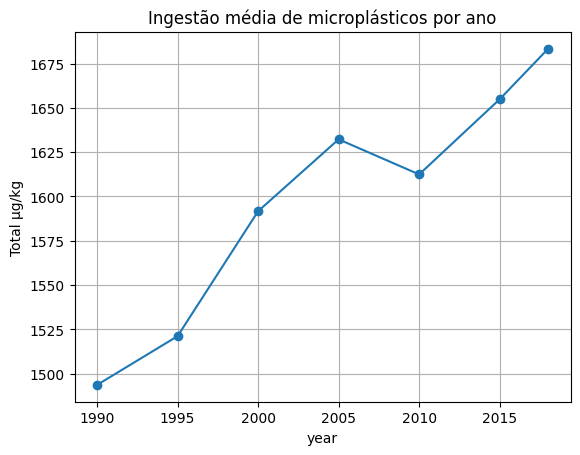

In [ ]:
# Agrupando por ano com a média de total_ug_per_kg ao longo do tempo
processed_microplastics.groupby('year')['total_ug_per_kg'].mean().plot(marker='o')
plt.title('Ingestão média de microplásticos por ano')
plt.ylabel('Total µg/kg')
plt.grid()
plt.show()

## **Há diferenças significativas entre regiões quanto à tendência?**

**O gráfico mostra a ingestão média anual de microplásticos (em µg/kg) por diferentes regiões do mundo entre 1990 e 2018. Observa-se que América do Norte, Europa Ocidental e Europa Oriental e Norte apresentam os maiores valores, com picos próximos a 2500 µg/kg, embora tenham uma leve queda após 2005. Oceania também mantém níveis elevados, mas com variações ao longo dos anos. Regiões como Norte da África e América Latina e Caribe apresentam valores intermediários, com tendência geral de crescimento. Já Sudeste Asiático e Leste Asiático, África Subsaariana e Ásia Ocidental e Sul apresentam os níveis mais baixos, embora o Sudeste Asiático e Leste Asiático mostre um aumento contínuo ao longo do período. Isso sugere disparidades regionais significativas na exposição a microplásticos, possivelmente refletindo diferenças em hábitos alimentares, industrialização e políticas ambientais.**



In [ ]:
best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

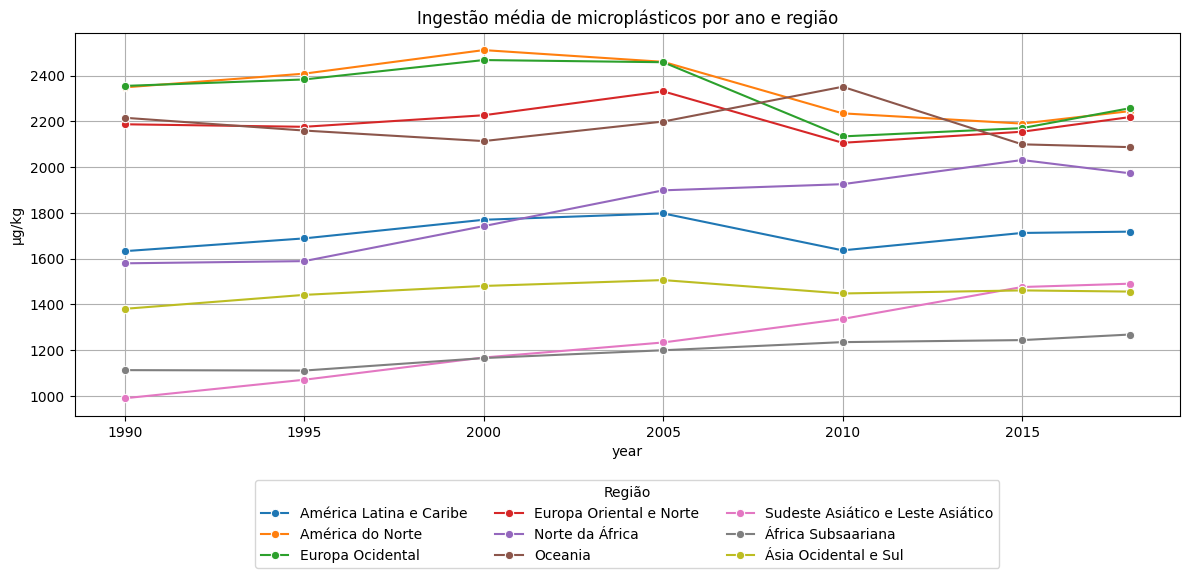

In [ ]:
# Agrupando por ano com a média de total_ug_per_kg ao longo do tempo, para cada região
region_trend = processed_microplastics.groupby(['region', 'year'])['total_ug_per_kg'].mean().reset_index()

# Plotando com uma linha por região
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=region_trend,
    x='year', y='total_ug_per_kg', hue='region', marker='o'
)
plt.title('Ingestão média de microplásticos por ano e região')
plt.ylabel('µg/kg')
plt.grid(True)
plt.legend(
    title='Região',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3  # Ajuste conforme o número de regiões
)
plt.tight_layout()
plt.show()

## **Como os clusters regionais variam ao longo dos anos?**

**Esta pergunta foi respondida com o apoio de três diferentes algoritmos de clusterização (Clusterização Hierárquica, K-Means e DBSCAN).**




In [ ]:
# Colunas alimentares
food_cols = ['cheese', 'yoghurt', 'total_milk', 'fruits', 'refined_grains',
             'whole_grains', 'nuts_and_seeds', 'total_processed_meats',
             'unprocessed_red_meats', 'fish', 'shellfish', 'eggs', 'total_salt',
             'added_sugars', 'non-starchy_vegetables', 'potatoes',
             'other_starchy_vegetables', 'beans_and_legumes', 'total_ug_per_kg']

# Agregação por região e ano
df_agg = processed_microplastics.groupby(['region', 'year'])[food_cols].mean().reset_index()

# Lista de anos disponíveis
years = sorted(df_agg['year'].unique())

### **Clusterização Hierárquica**

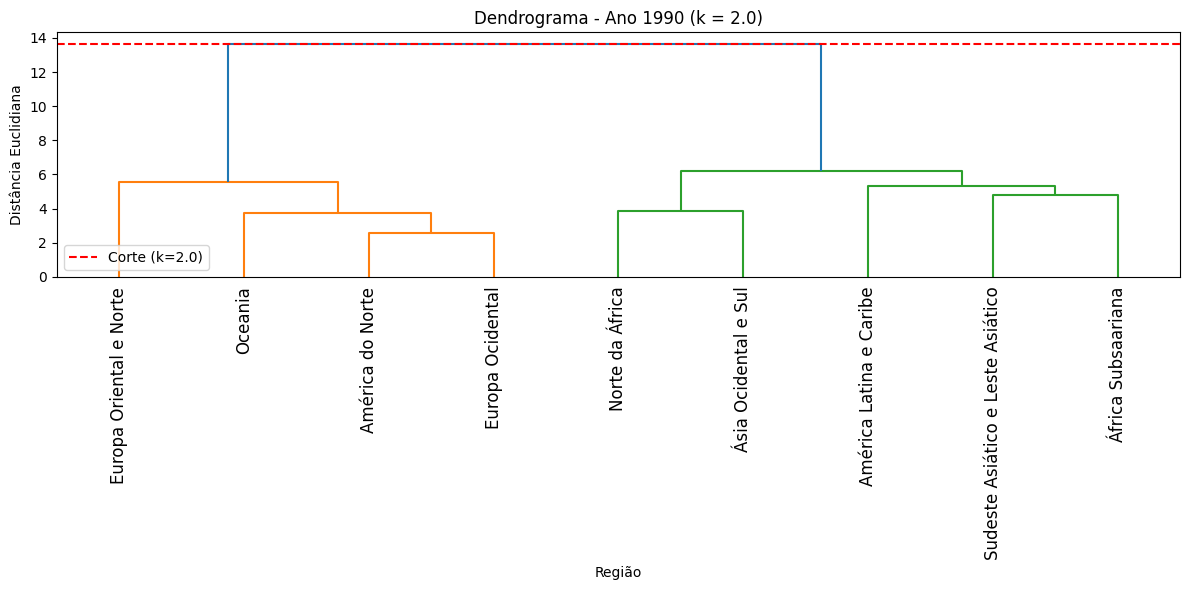

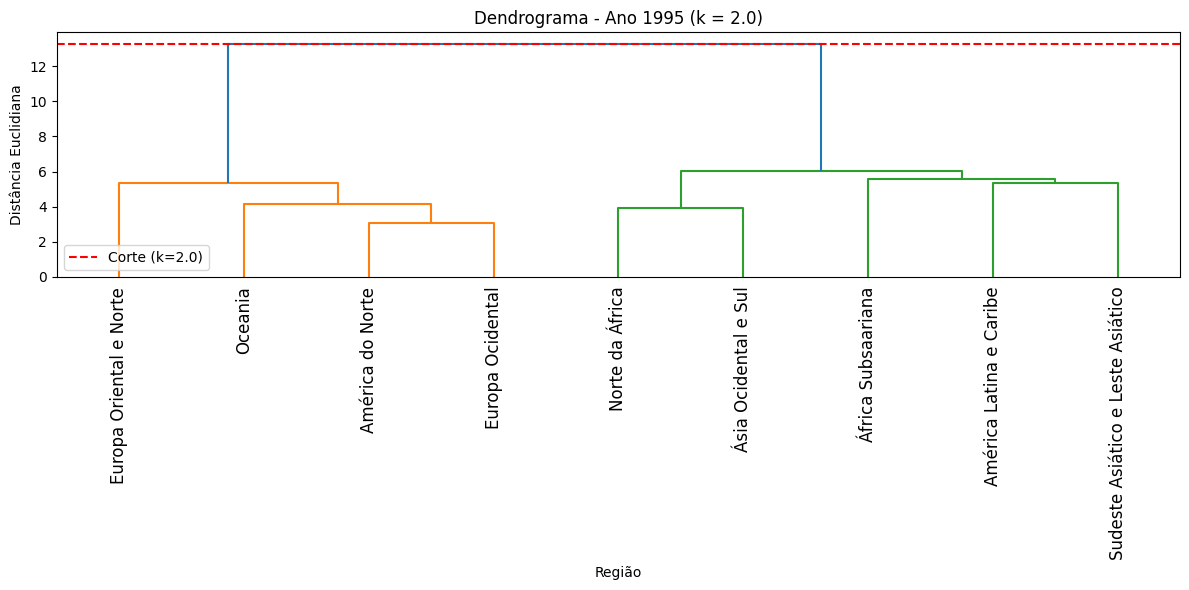

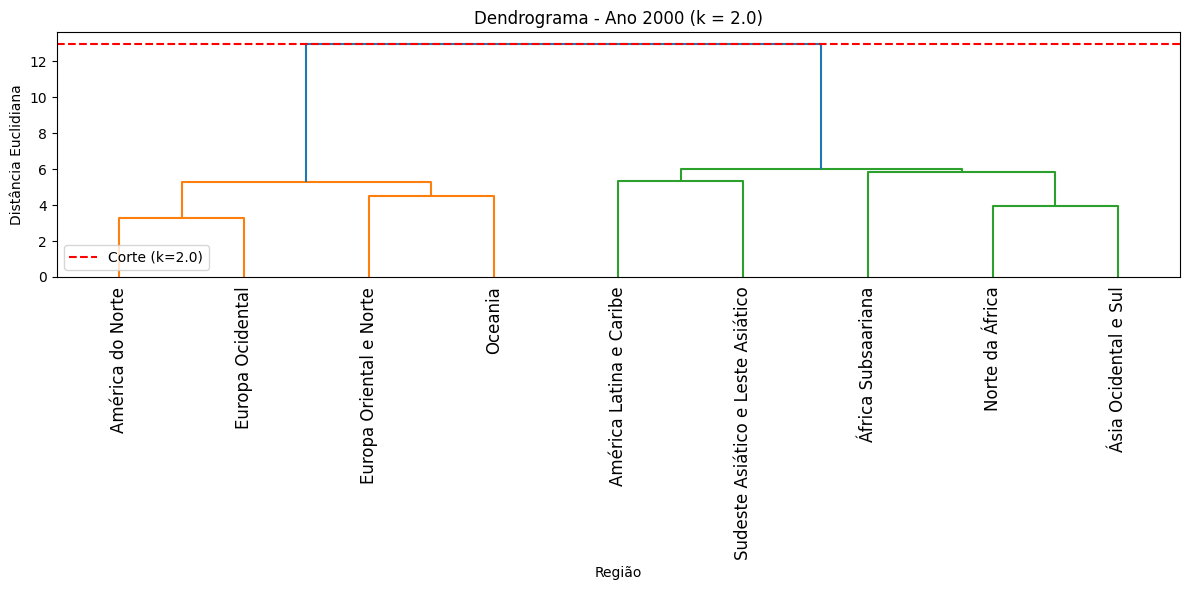

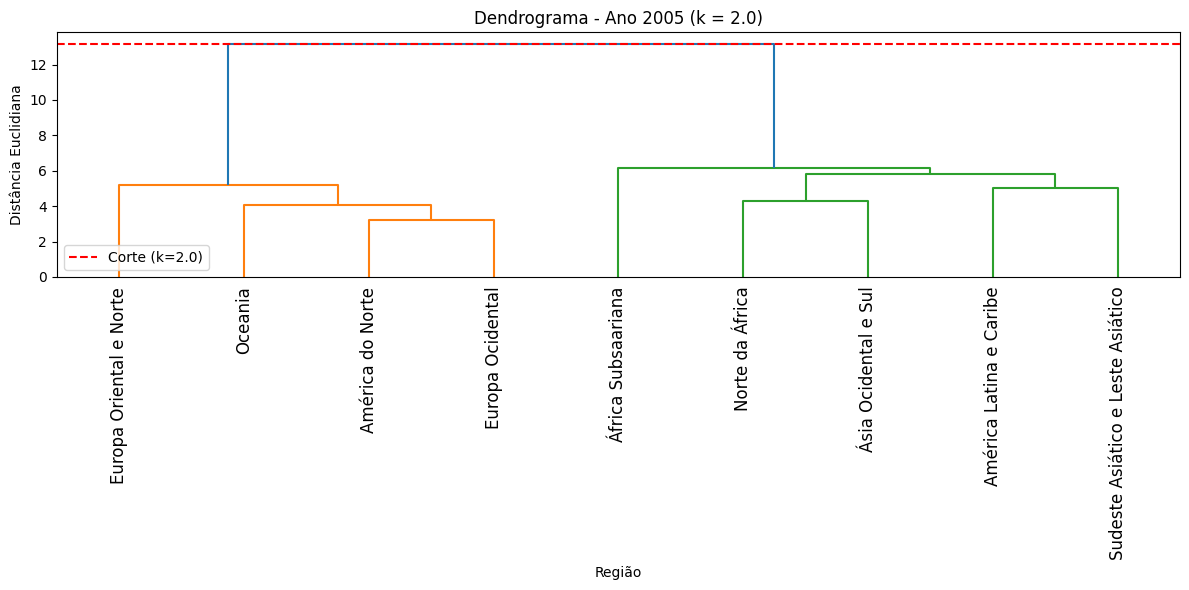

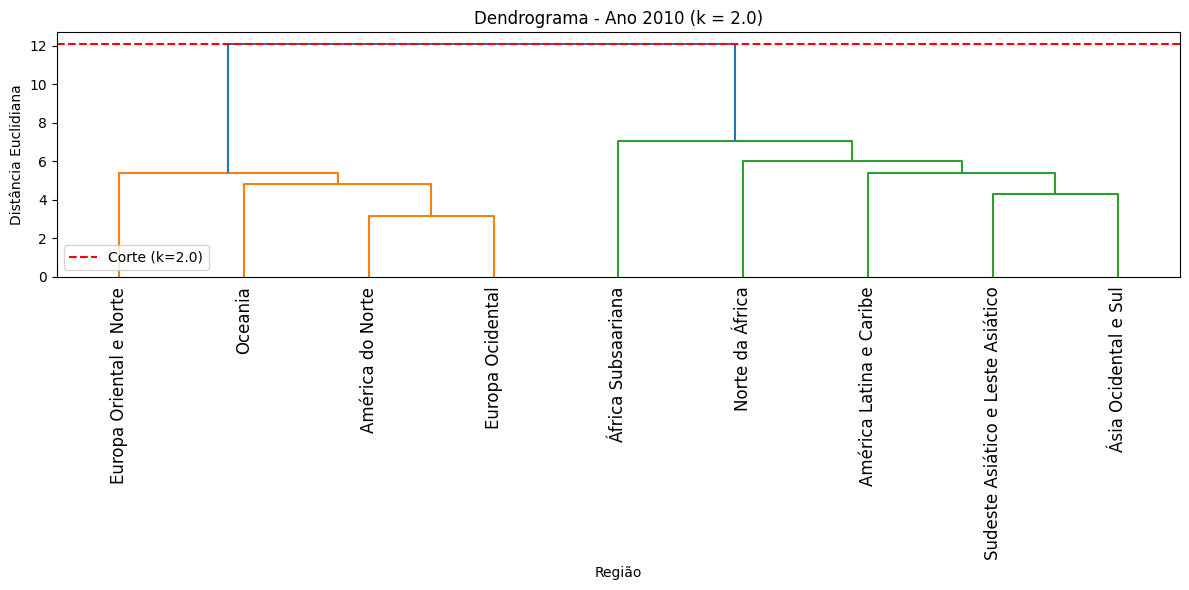

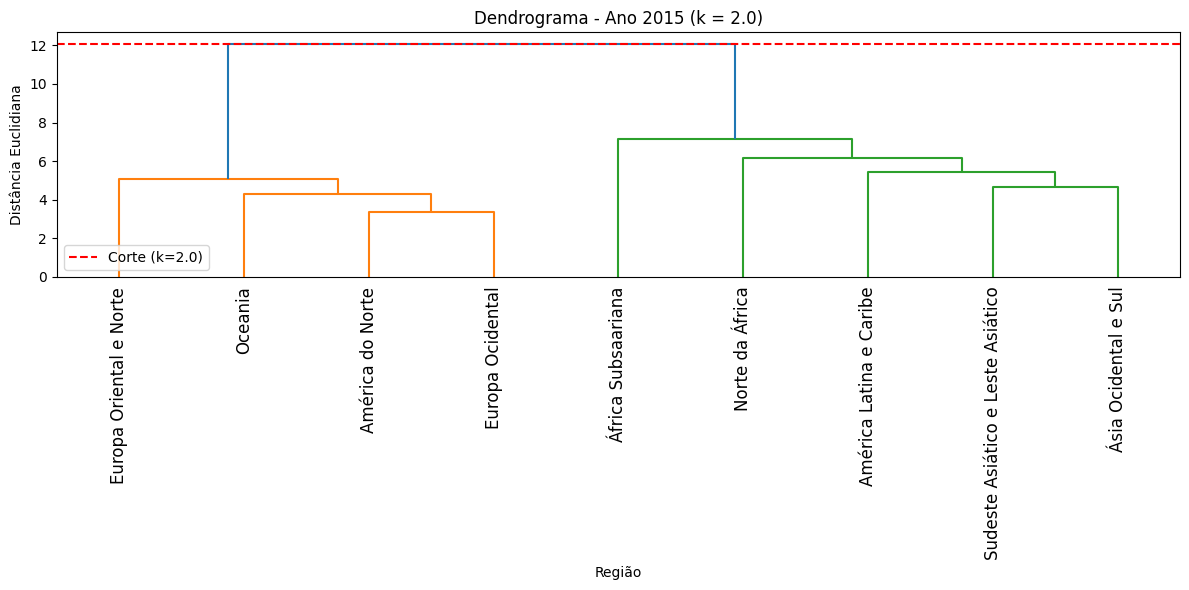

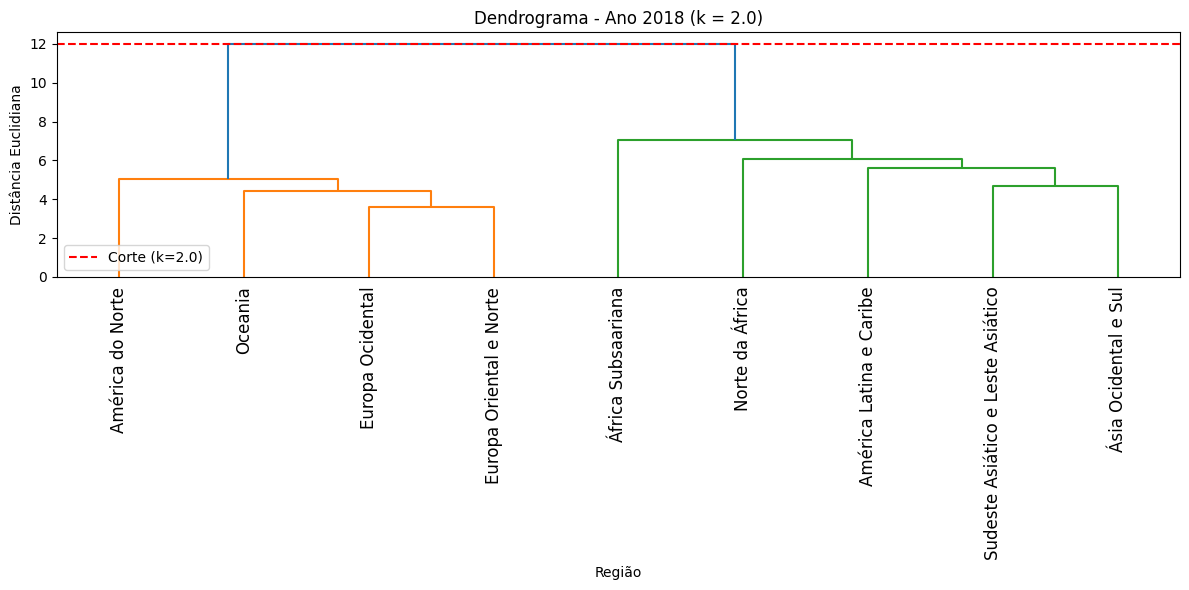

In [ ]:
# Geração de dendogramas com os melhores paramêtros
parametros_aggl = {
    'n_clusters': range(2, 6)
}

df_resultados, df_melhores, _ = clusterizar_gridsearch(
    df_agg=df_agg,
    food_cols=food_cols,
    anos=years,
    algoritmo_cls=AgglomerativeClustering,
    param_grid=parametros_aggl,
    usar_dendrograma=True
)

In [ ]:
df_melhores # melhores paramêtros para o dendograma

,year,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,1990.0,2.0,0.387143,0.878140,8.352079
1,1995.0,2.0,0.357784,0.933755,7.398487
2,2000.0,2.0,0.335805,0.975724,6.772651
3,2005.0,2.0,0.351923,0.940584,7.178803
4,2010.0,2.0,0.285601,1.098199,5.236567
5,2015.0,2.0,0.285218,1.088563,5.192695
6,2018.0,2.0,0.277115,1.110318,5.075041


### **K-Means**

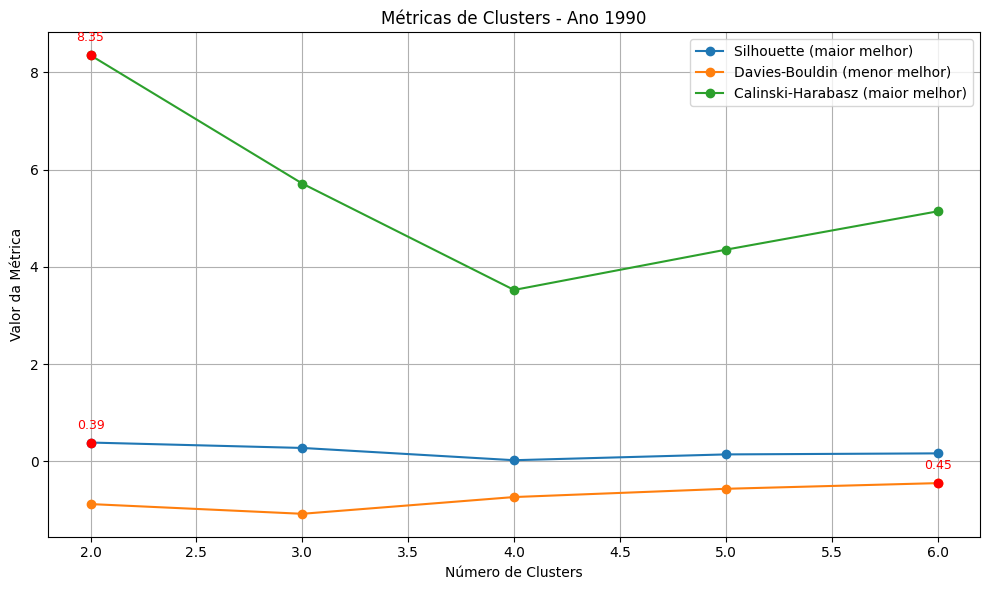

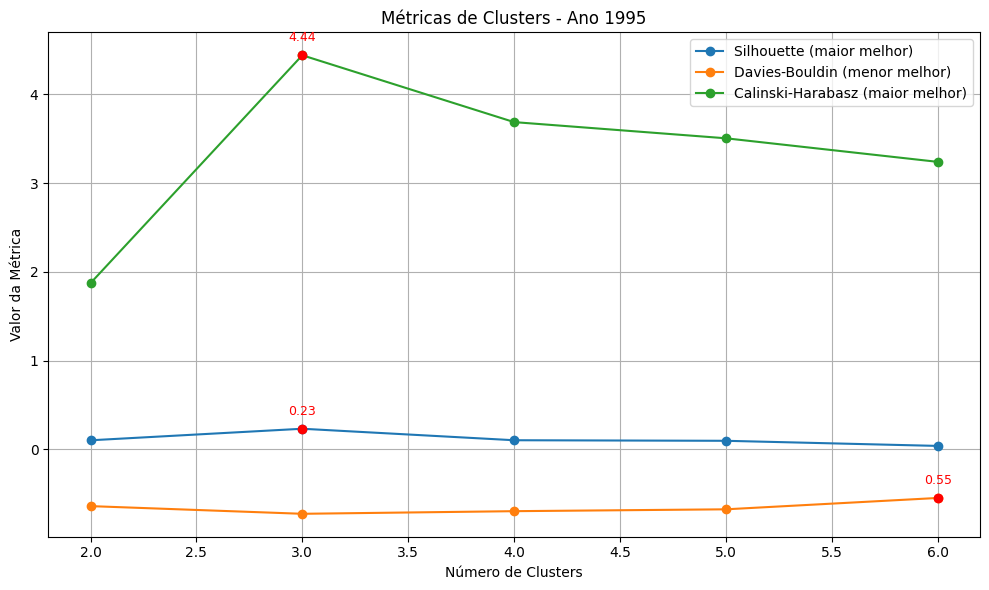

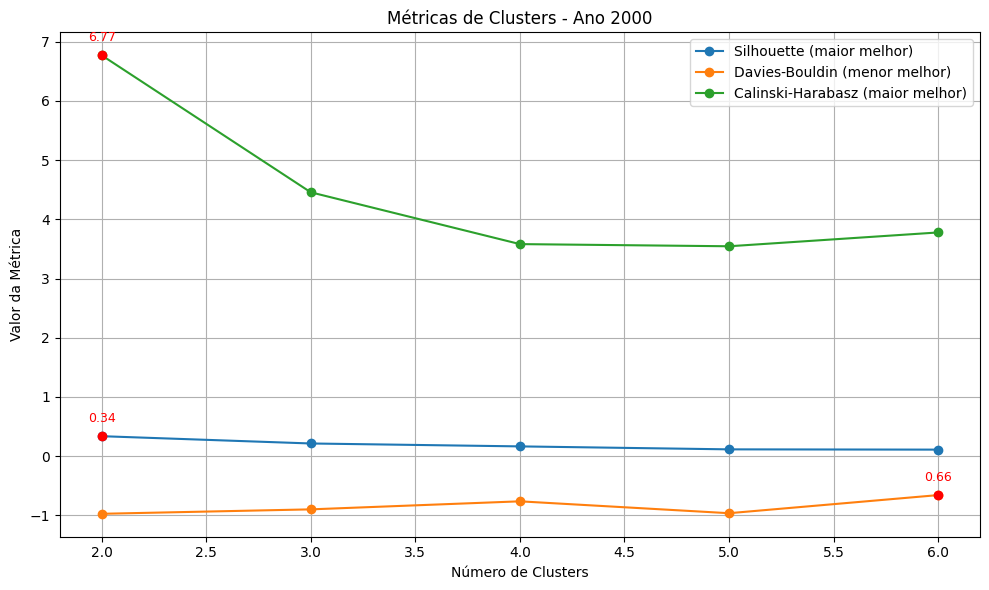

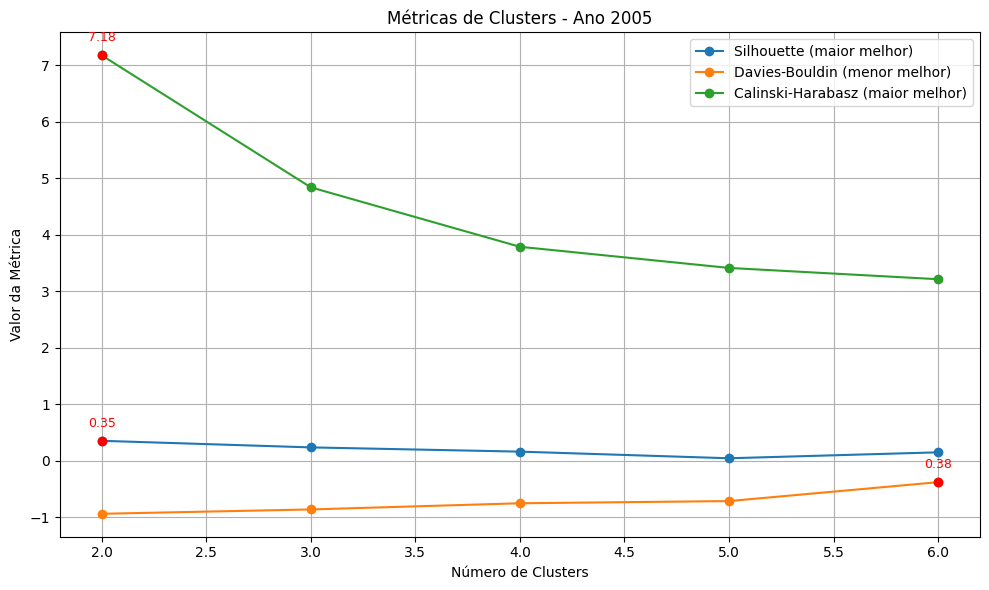

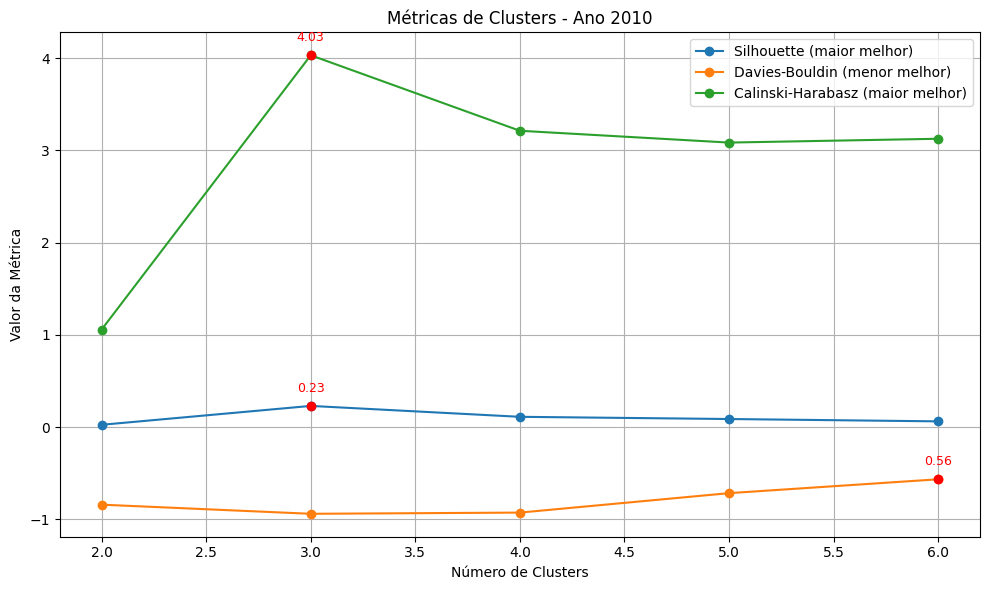

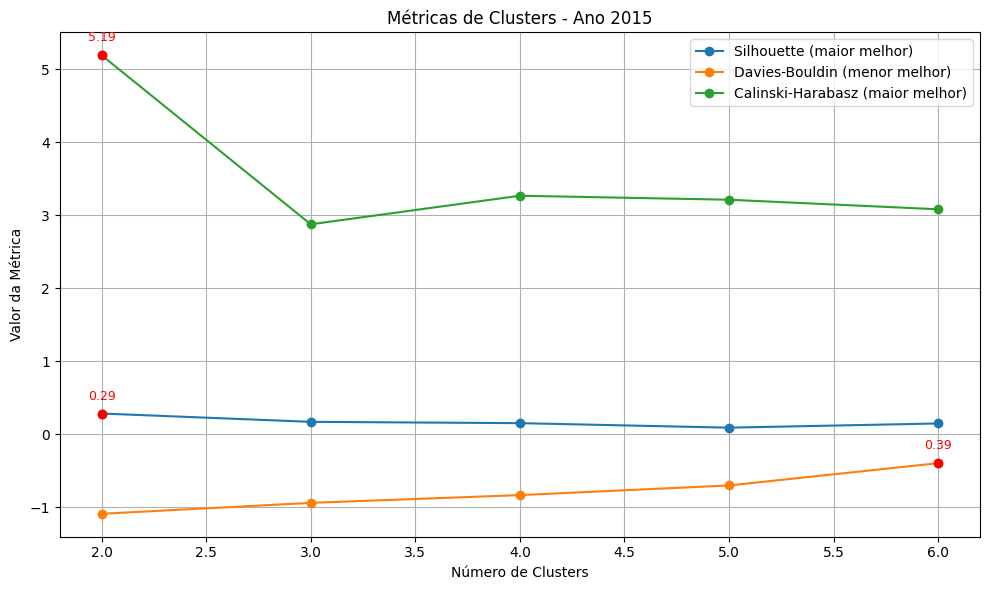

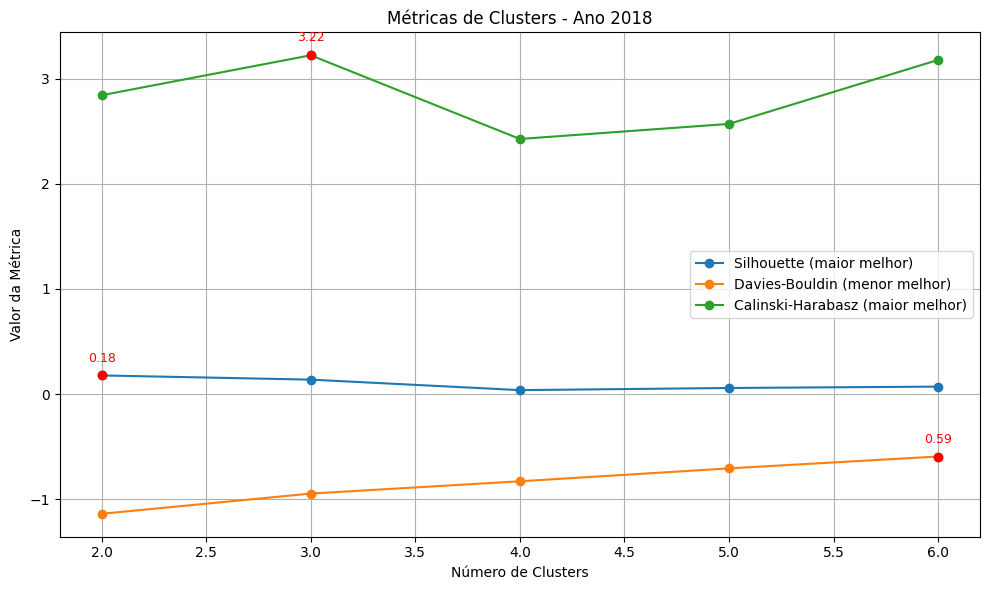

In [ ]:
# Parâmetros para testar o KMeans
parametros_kmeans = {
    'n_clusters': range(2, 7)  # Testa de 2 a 6 clusters
}

# Chamada da função unificada
df_resultados, df_melhores, df_clusters = clusterizar_gridsearch(
    df_agg=df_agg,
    food_cols=food_cols,
    anos=years,
    algoritmo_cls=KMeans,
    param_grid=parametros_kmeans,
    usar_dendrograma=False
)

In [ ]:
df_melhores # melhores paramêtros para o KMeans

,year,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,1990.0,2.0,0.387143,0.878140,8.352079
1,1995.0,3.0,0.232012,0.726057,4.438995
2,2000.0,2.0,0.335805,0.975724,6.772651
3,2005.0,2.0,0.351923,0.940584,7.178803
4,2010.0,3.0,0.230349,0.939078,4.031414
5,2015.0,2.0,0.285218,1.088563,5.192695
6,2018.0,2.0,0.176858,1.139625,2.842772


In [ ]:
# Imprimir as regiões que foram clusterizadas e a distribuição de clusters

for ano, df in df_clusters.groupby('year'):
    print(f"\n{'='*40}")
    print(f"Clusters para o ano {ano}")
    print(f"{'-'*40}")

    # Exibe 'region' como índice só para formatação na saída
    df_temp = df.set_index('region')
    print(df_temp[['cluster']].to_string())

    print(f"\nDistribuição de clusters - Ano {ano}")
    print(f"{'-'*40}")
    print(df['cluster'].value_counts().sort_index().to_string())
    print(f"{'='*40}\n")


Clusters para o ano 1990
----------------------------------------
                                   cluster
region                                    
América Latina e Caribe                  1
América do Norte                         0
Europa Ocidental                         0
Europa Oriental e Norte                  0
Norte da África                          1
Oceania                                  0
Sudeste Asiático e Leste Asiático        1
África Subsaariana                       1
Ásia Ocidental e Sul                     1

Distribuição de clusters - Ano 1990
----------------------------------------
cluster
0    4
1    5


Clusters para o ano 1995
----------------------------------------
                                   cluster
region                                    
América Latina e Caribe                  2
América do Norte                         0
Europa Ocidental                         0
Europa Oriental e Norte                  0
Norte da África                   

### **DBSCAN**

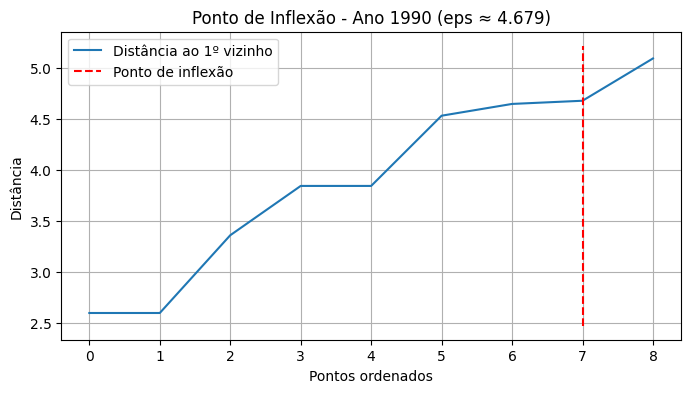

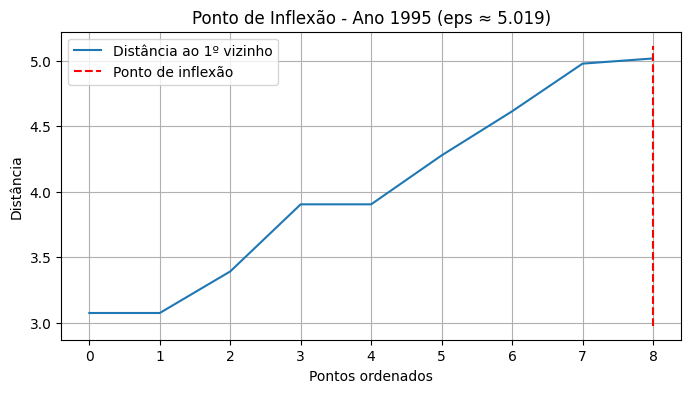

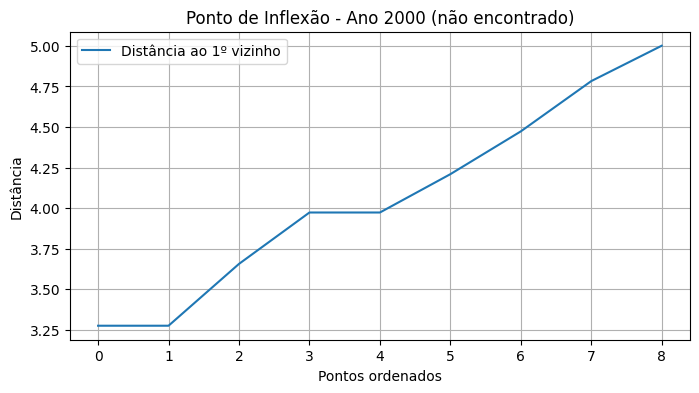

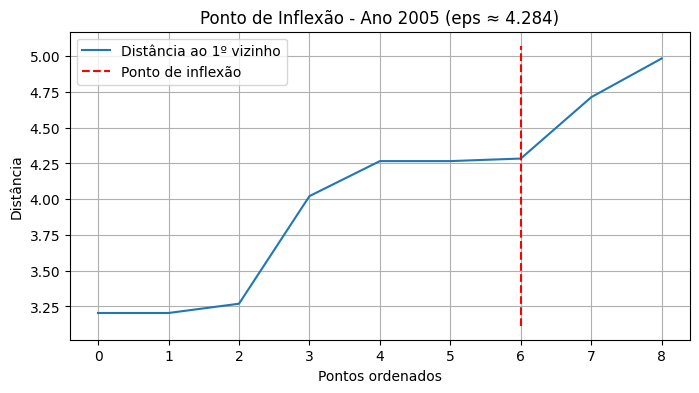

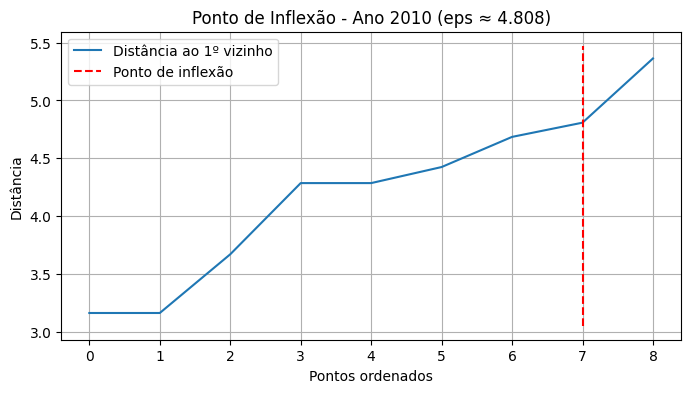

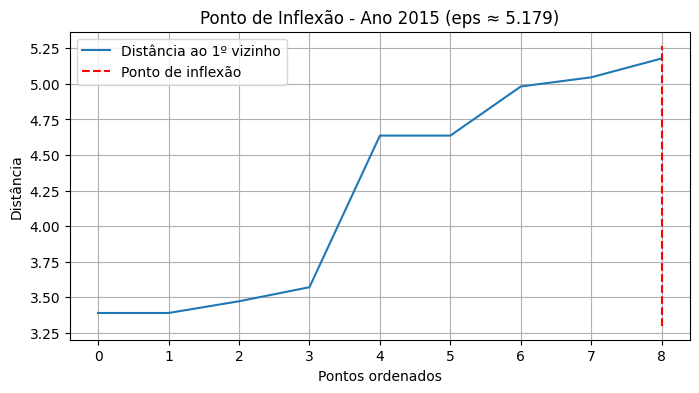

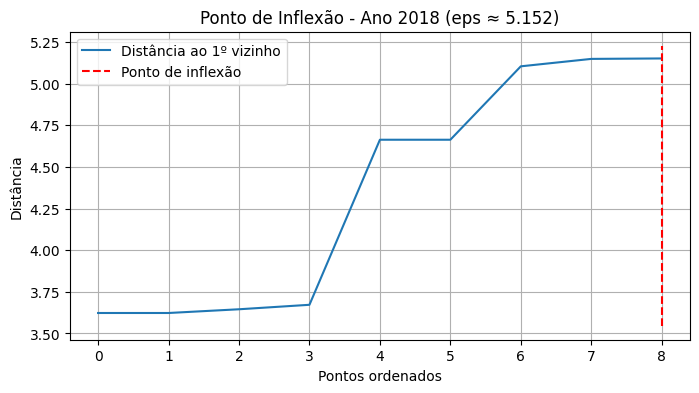

In [ ]:
# Melhores eps (epsilon) -- raio máximo para que dois pontos sejam considerados vizinhos
eps_por_ano = sugerir_eps_para_todos_anos(df_agg, food_cols, anos=years)

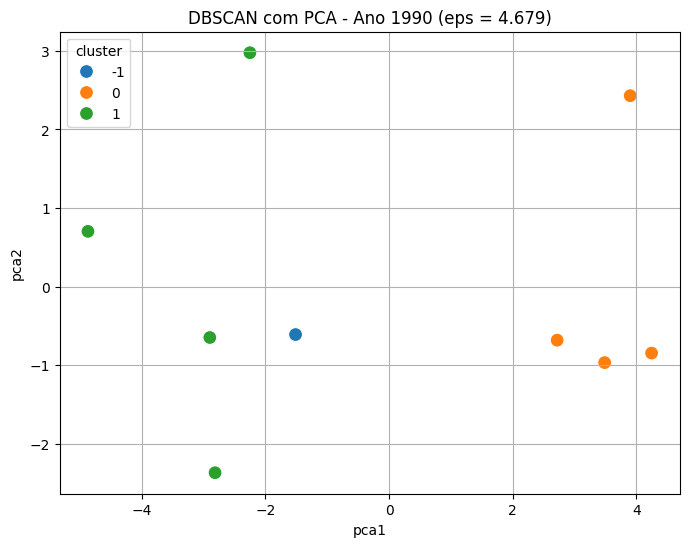

Silhouette Score não calculado (clusters insuficientes ou presença de ruído).


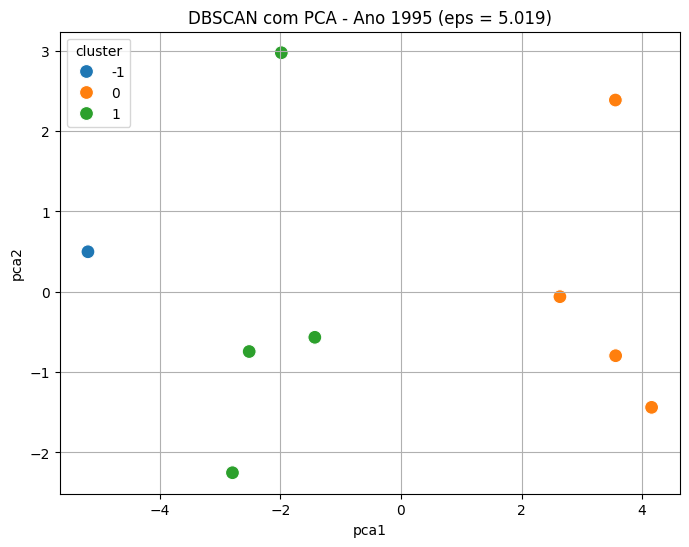

Silhouette Score não calculado (clusters insuficientes ou presença de ruído).


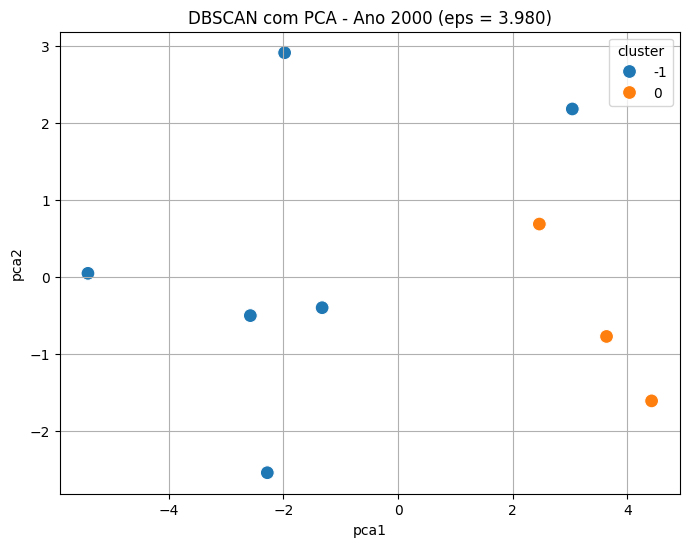

Silhouette Score não calculado (clusters insuficientes ou presença de ruído).


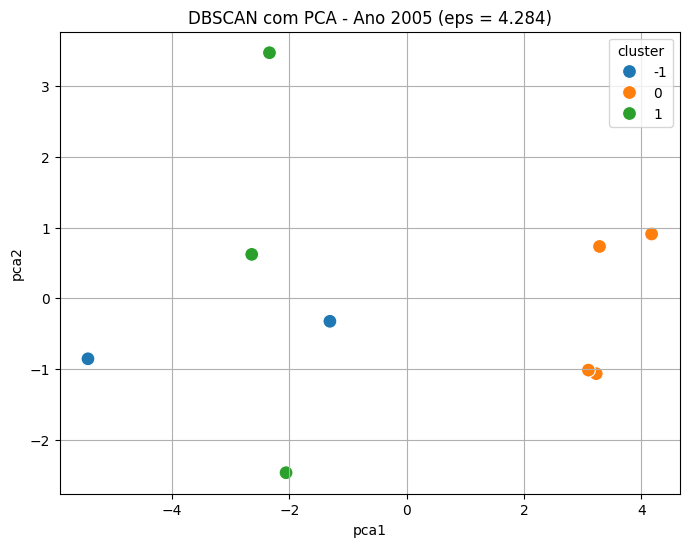

Silhouette Score não calculado (clusters insuficientes ou presença de ruído).


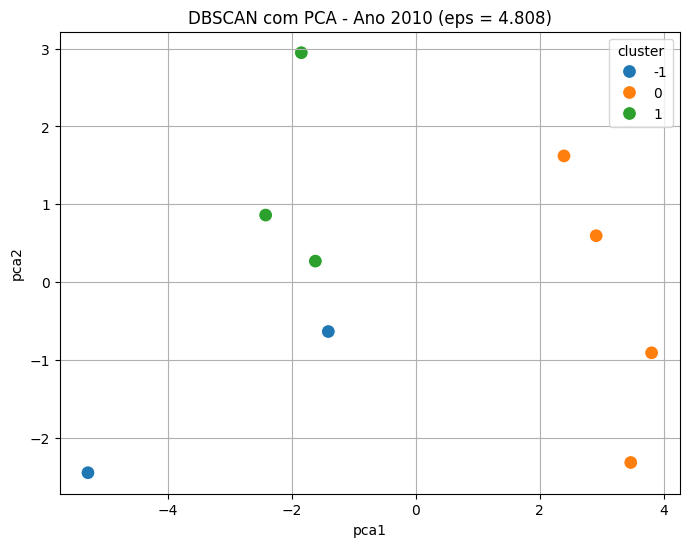

Silhouette Score não calculado (clusters insuficientes ou presença de ruído).


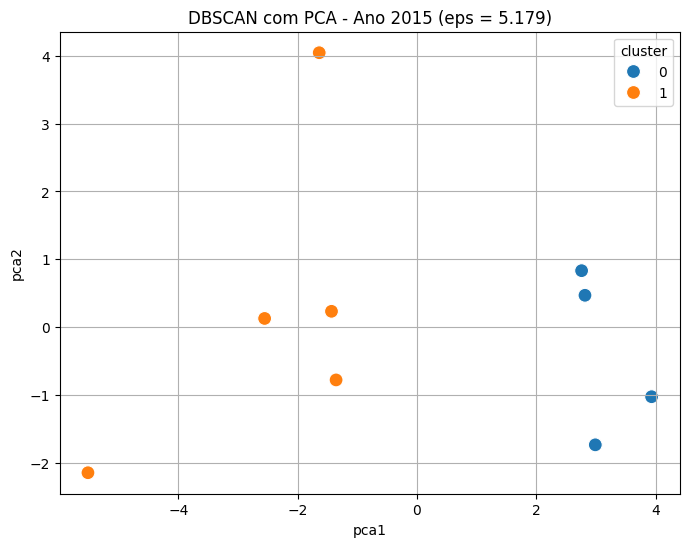

Silhouette Score: 0.285


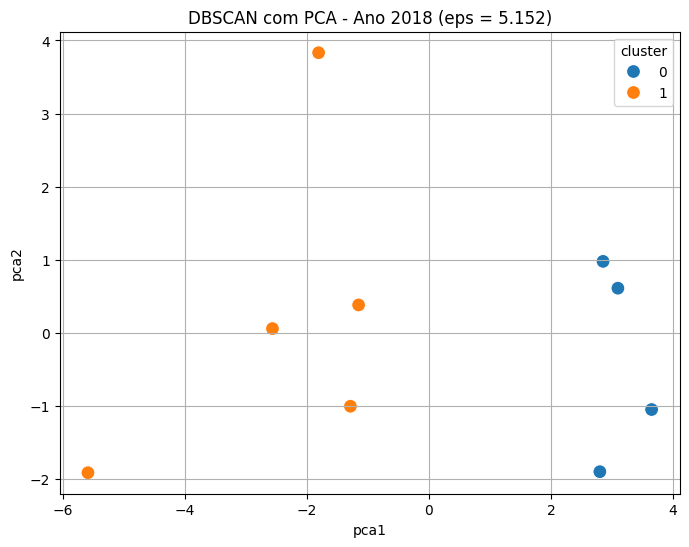

Silhouette Score: 0.277


In [ ]:
eps_por_ano[np.int64(2000)] = np.float64(3.98) # não foi encontrado ponto de inflexão automaticamente

# Gerar gráficos DBSCAN com melhores eps
resultados_por_ano = aplicar_dbscan_para_todos_anos(
    df_agg=df_agg,
    food_cols=food_cols,
    anos=years,
    eps_por_ano=eps_por_ano,
    min_samples=3
)

In [ ]:
# Imprimir as regiões que foram clusterizadas e a distribuição de clusters

for ano, df in resultados_por_ano.items():
    print(f"\n{'='*40}")
    print(f"Clusters para o ano {ano}")
    print(f"{'-'*40}")
    # Imprime a coluna cluster com região formatada
    print(df[['cluster']].to_string())

    print(f"\nDistribuição de clusters - Ano {ano}")
    print(f"{'-'*40}")
    print(df['cluster'].value_counts().to_string())
    print(f"{'='*40}\n")


Clusters para o ano 1990
----------------------------------------
                                   cluster
region                                    
América Latina e Caribe                 -1
América do Norte                         0
Europa Ocidental                         0
Europa Oriental e Norte                  0
Norte da África                          1
Oceania                                  0
Sudeste Asiático e Leste Asiático        1
África Subsaariana                       1
Ásia Ocidental e Sul                     1

Distribuição de clusters - Ano 1990
----------------------------------------
cluster
 0    4
 1    4
-1    1


Clusters para o ano 1995
----------------------------------------
                                   cluster
region                                    
América Latina e Caribe                  1
América do Norte                         0
Europa Ocidental                         0
Europa Oriental e Norte                  0
Norte da África         